# DCTによる圧縮画像を作る

In [2]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.fftpack import dct, idct
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
from skimage.util import crop
import pandas as pd

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]

    def get_block(self, col, row):
        return self.img[col * 8 : (col + 1) * 8, row * 8 : (row + 1) * 8]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

# 画像の用意
MONO_DIR_PATH = "../../Mono/"
AIRPLANE = ImageLoader(MONO_DIR_PATH + "airplane512.bmp")
BARBARA = ImageLoader(MONO_DIR_PATH + "barbara512.bmp")
BOAT = ImageLoader(MONO_DIR_PATH + "boat512.bmp")
GOLDHILL = ImageLoader(MONO_DIR_PATH + "goldhill512.bmp")
LENNA = ImageLoader(MONO_DIR_PATH + "lenna512.bmp")
MANDRILL = ImageLoader(MONO_DIR_PATH + "mandrill512.bmp")
MILKDROP = ImageLoader(MONO_DIR_PATH + "milkdrop512.bmp")
SAILBOAT = ImageLoader(MONO_DIR_PATH + "sailboat512.bmp")
# SAILBOAT256 = ImageLoader(MONO_DIR_PATH + "SAILBOAT.bmp")
TEST02 = ImageLoader(MONO_DIR_PATH + "test02.bmp")
TEST19 = ImageLoader(MONO_DIR_PATH + "test19.bmp")
N8RGB = ImageLoader(MONO_DIR_PATH + "N8RGB.bmp")
N6RGB = ImageLoader(MONO_DIR_PATH + "N6RGB.bmp")

N = 32

# DCT

## 基底関数

$$
\phi_k[i] = \begin{cases}
\cfrac{1}{\sqrt{N}}  \quad \quad \quad (k=0) \\
\sqrt{\cfrac{2}{N}} \cos \left({\cfrac{\pi}{2N}(2i+1)k}\right) \quad  (k=1,2,...,N-1) 
\end{cases}
$$

In [3]:
class DCT:
    def __init__(self, N):
        self.N = N  # データ数
        # 1次元DCTの基底ベクトルの生成
        self.phi_1d = np.array([self.phi(i) for i in range(self.N)])
        # 2次元DCTの基底ベクトルの格納
        self.phi_2d = np.zeros((N, N))

    def phi(self, k):
        """ 離散コサイン変換(DCT)の基底関数 """
        # DCT-II
        if k == 0:
            return np.ones(self.N) / np.sqrt(self.N)
        else:
            return np.sqrt(2.0 / self.N) * np.cos(
                (k * np.pi / (2 * self.N)) * (np.arange(self.N) * 2 + 1)
            )

    def dct(self, data):
        """ 1次元離散コサイン変換を行う """
        return self.phi_1d.dot(data)

    def idct(self, c):
        """ 1次元離散コサイン逆変換を行う """
        return np.sum(self.phi_1d.T * c, axis=1)

    def get_dct2_phi(self, y, x):
        """ 2次元離散コサイン変換の基底を返す """
        phi_x, phi_y = np.meshgrid(self.phi_1d[x], self.phi_1d[y])
        return phi_x * phi_y

    def get_dct2(self, y, x, data):
        """ i,jの2次元DCT係数を返す """
        phi_2d_phi = np.zeros((self.N, self.N))
        phi_2d_phi = self.get_dct2_phi(y, x)
        return np.sum(np.sum(phi_2d_phi * data))

    def dct2(self, data):
        """ 2次元離散コサイン変換を行う """
        for y in range(self.N):
            for x in range(self.N):
                self.phi_2d[y, x] = self.get_dct2(y, x, data)

        return self.phi_2d

    def idct2(self, c):
        """ 2次元離散コサイン逆変換を行う """
        idct2_data = np.zeros((self.N, self.N))
        phi_2d_phi = np.zeros((self.N, self.N))
        for y in range(self.N):
            for x in range(self.N):
                phi_2d_phi = self.get_dct2_phi(y, x)
                idct2_data += c[y, x] * phi_2d_phi

        return idct2_data

# MSDS

In [4]:
def msds(N,arr):
    w_e = 0
    e_e = 0
    n_e = 0
    s_e = 0
    nw_e = 0
    ne_e = 0
    sw_e = 0
    se_e = 0
    for row in range(arr.shape[0] // N):
        for col in range(arr.shape[1] // N):
            f_block = arr[row * N : (row + 1) * N, col * N : (col + 1) * N]
            # w
            if col == 0:
                w_block = np.fliplr(f_block)
            else:
                w_block = arr[row * N : (row + 1) * N, (col - 1) * N : col * N]
            # e
            if col == arr.shape[1] // N - 1:
                e_block = np.fliplr(f_block)
            else:
                e_block = arr[row * N : (row + 1) * N, (col + 1) * N : (col + 2) * N]
            # n
            if row == 0:
                n_block = np.flipud(f_block)
            else:
                n_block = arr[(row - 1) * N : row * N, col * N : (col + 1) * N]
            # s
            if row == arr.shape[0] // N - 1:
                s_block = np.flipud(f_block)
            else:
                s_block = arr[(row + 1) * N : (row + 2) * N, col * N : (col + 1) * N]

            w_d1 = f_block[:, 0] - w_block[:, N-1]
            e_d1 = f_block[:, N-1] - e_block[:, 0]
            n_d1 = f_block[0, :] - n_block[N-1, :]
            s_d1 = f_block[N-1, :] - s_block[0, :]

            w_d2 = (w_block[:, N-1] - w_block[:, N-2] + f_block[:, 1] - f_block[:, 0]) / 2
            e_d2 = (e_block[:, 1] - e_block[:, 0] + f_block[:, N-1] - f_block[:, N-2]) / 2
            n_d2 = (n_block[N-1, :] - n_block[N-2, :] + f_block[1, :] - f_block[0, :]) / 2
            s_d2 = (s_block[1, :] - s_block[0, :] + f_block[N-1, :] - f_block[N-2, :]) / 2

            w_e += np.sum((w_d1 - w_d2) ** 2 )
            e_e += np.sum((e_d1 - e_d2) ** 2 )
            n_e += np.sum((n_d1 - n_d2) ** 2)
            s_e += np.sum((s_d1 - s_d2) ** 2)

            # nw
            if row == 0 or col == 0:
                nw_block = np.flipud(np.fliplr(f_block))
            else:
                nw_block = arr[(row - 1) * N : row * N, (col - 1) * N : col * N]
            # ne
            if row == 0 or col == arr.shape[1] // N - 1:
                ne_block = np.flipud(np.fliplr(f_block))
            else:
                ne_block = arr[(row-1) * N : row * N, (col + 1) * N : (col + 2) * N]
            # sw
            if row == arr.shape[0] // N -1 or col == 0:
                sw_block = np.flipud(np.fliplr(f_block))
            else:
                sw_block = arr[row * N : (row+1) * N, (col-1) * N : col * N]
            # se
            if  row == arr.shape[0]//N-1 or col == arr.shape[0] // N -1:
                se_block = np.flipud(np.fliplr(f_block))
            else:
                se_block = arr[(row + 1) * N : (row + 2) * N, (col+1) * N : (col + 2) * N]

            nw_g1 = f_block[0, 0] - nw_block[N-1, N-1]
            ne_g1 = f_block[0, N-1] - ne_block[N-1, 0]
            sw_g1 = f_block[N-1, 0] - sw_block[0, N-1]
            se_g1 = f_block[N-1, N-1] - se_block[0, 0]

            nw_g2 = (nw_block[N-1,N-1] - nw_block[N-2,N-2] + f_block[1,1] - f_block[0,0])/2
            ne_g2 = (ne_block[N-1,0] - ne_block[N-2,1] + f_block[1,N-2] - f_block[0,N-1])/2
            sw_g2 = (sw_block[0,N-1] - nw_block[1,N-2] + f_block[N-2,1] - f_block[N-1,0])/2
            se_g2 = (nw_block[0,0] - nw_block[1,1] + f_block[N-2,N-2] - f_block[N-1,N-1])/2

            nw_e += (nw_g1 - nw_g2) ** 2 
            ne_e += (ne_g1 - ne_g2) ** 2 
            sw_e += (sw_g1 - sw_g2) ** 2 
            se_e += (se_g1 - se_g2) ** 2 

    MSDSt = (w_e + e_e + n_e + s_e + nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    MSDS1 = (w_e + e_e + n_e + s_e)/ ((arr.shape[0]/N)**2)
    MSDS2 = (nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    return MSDSt, MSDS1, MSDS2

# 32x32ブロックでDCT

### DCT

In [5]:
IMG = N8RGB

In [6]:
Fk = np.zeros(IMG.img.shape)

In [7]:
for row in range(IMG.img.shape[0] // 32):
    for col in range(IMG.img.shape[1] // 32):
        block = IMG.img[row * 32 : (row + 1) * 32, col * 32 : (col + 1) * 32]
        c = scipy.fftpack.dct(
            scipy.fftpack.dct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
        )
        Fk[row * 32 : (row + 1) * 32, col * 32 : (col + 1) * 32] = c
        

In [7]:
low_3_value = 0
others_value = 0

In [22]:
for row in range(IMG.img.shape[0] // 32):
    for col in range(IMG.img.shape[1] // 32):
        block = Fk[row * 32 : (row + 1) * 32, col * 32 : (col + 1) * 32]
        low_3_value += np.abs(block[0, 1]) + np.abs(block[1, 0]) + np.abs(block[1, 1])
        others_value += (
            np.sum(np.sum(np.abs(block)))
            - np.abs(block[0, 0])
            - np.abs(block[0, 1])
            - np.abs(block[1, 0])
            - np.abs(block[1, 1])
        )
        

### 低域3成分 (0,1)(1,0)(1,1)の絶対値の和

In [9]:
low_3_value

165193.16854539167

In [10]:
others_value

1826429.5111109032

### IDCT

In [8]:
recover = np.zeros(Fk.shape)

In [9]:
for row in range(Fk.shape[0] // 32):
    for col in range(Fk.shape[1] // 32):
        block = Fk[row * 32 : (row + 1) * 32, col * 32 : (col + 1) * 32]
        data = scipy.fftpack.idct(
            scipy.fftpack.idct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
        )
        recover[row * 32 : (row + 1) * 32, col * 32 : (col + 1) * 32] = data
        

findfont: Font family ['Source Han Sans JP'] not found. Falling back to DejaVu Sans.


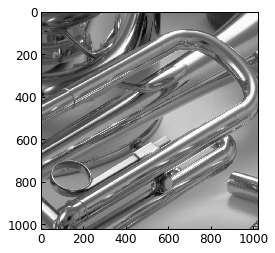

In [10]:
plt.imshow(recover, cmap="gray")

In [14]:
recover[0, 0:10]

array([30., 13., 15., 18., 19., 15., 15., 12., 15., 18.])

In [15]:
IMG.img[0, 0:10]

array([30, 13, 15, 18, 19, 15, 15, 12, 15, 18], dtype=uint8)

ちゃんと復元できてる

# 量子化テーブル

In [11]:
# NN = 32
bpp = np.arange(0.2,0.8,0.05)
Q_Fk = np.zeros(Fk.shape)
for i in bpp:
    low = 0
    high = 200
    for j in range(20):
        mid = (low + high)/2
        
        Q = mid
        Q_Luminance = np.ones((32,32)) * Q

        Q_Fk = np.zeros(Fk.shape)
        for row in range(IMG.img.shape[0] // 32):
            for col in range(IMG.img.shape[1] // 32):
                block = Fk[row * 32 : (row + 1) * 32, col * 32 : (col + 1) * 32]
                # 量子化
                block = np.round(block / Q_Luminance)
                # 逆量子化
                block = block * Q_Luminance
                Q_Fk[row * 32 : (row + 1) * 32, col * 32 : (col + 1) * 32] = block

        qfk = pd.Series(Q_Fk.flatten())
#         qfk = pd.Series(crop(Q_Fk,NN).flatten())
        pro = qfk.value_counts() / qfk.value_counts().sum()
        S = 0
        for pi in pro:
            S -= pi * np.log2(pi)

        if S < i:
            high = mid
        elif S > i:
            low = mid   
            
    Q_recover = np.zeros(Q_Fk.shape)
    for row in range(Q_Fk.shape[0] // 32):
        for col in range(Q_Fk.shape[1] // 32):
            block = Q_Fk[row * 32 : (row + 1) * 32, col * 32 : (col + 1) * 32]
            data = scipy.fftpack.idct(
                scipy.fftpack.idct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
            )
            Q_recover[row * 32 : (row + 1) * 32, col * 32 : (col + 1) * 32] = data

    Q_recover = np.round(Q_recover)
    MSE = np.sum(np.sum(np.power((IMG.img - Q_recover), 2))) / (
        Q_Fk.shape[0] * Q_Fk.shape[1]
    )
#     MSE = np.sum(np.sum(np.power((crop(IMG.img,NN) - crop(Q_recover,NN)), 2))) / (
#         crop(Q_Fk.shape[0],NN) * crop(Q_Fk.shape[1],NN)
#     )
    PSNR = 10 * np.log10(255 * 255 / MSE)
    MSSIM = ssim(IMG.img,Q_recover.astype(IMG.img.dtype),gaussian_weights=True,sigma=1.5,K1=0.01,K2=0.03)
#     MSSIM = ssim(crop(IMG.img,NN),crop(Q_recover,NN).astype(IMG.img.dtype),gaussian_weights=True,sigma=1.5,K1=0.01,K2=0.03)
    MSDSt, MSDS1, MSDS2 = msds(32,Q_recover)
    print("S=",S)
    print(Q,PSNR,MSSIM,MSDS1,MSDS2)


S= 0.20000208427462496
83.74576568603516 32.264568076963506 0.8523622388150561 31935.9169921875 6902.6787109375
S= 0.24999591215196654
63.09986114501953 33.74714071593707 0.8788000758297088 25154.72900390625 6368.60302734375
S= 0.2999951428248396
49.76367950439453 35.0031758950963 0.8986489669926829 21405.9658203125 5968.477783203125
S= 0.35000317542191434
40.49510955810547 36.10095484532882 0.9143873357627308 18586.6611328125 5689.013427734375
S= 0.3999955440825755
33.82549285888672 37.07009403592525 0.9259186992692602 16714.376953125 5679.6630859375
S= 0.45000269559562833
28.635597229003906 37.9743043416044 0.9364145384352194 15158.11474609375 5427.58984375
S= 0.5000002711800033
24.64122772216797 38.778575912741566 0.9443683304457848 13855.22119140625 5288.9296875
S= 0.5499990130087566
21.36707305908203 39.53183889798404 0.9522213643288522 12848.2470703125 5143.02734375
S= 0.6000033155985401
18.79749298095703 40.21019282500821 0.9576745727313591 12311.84130859375 5065.646240234375
S=